This script is used to perform experiments with an expressive Lipschitz-constrained network architecture. Takes about 15 minutes for 10 loops


In [1]:
!pip install --quiet foolbox

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 2.6 MB/s eta 0:00:00


In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
import time
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
import foolbox as fb
import math
from sklearn.model_selection import train_test_split
from datetime import datetime

In [25]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [4]:
dimension = 4 # dimension of dataset
noise = True # add noise to the dataset
dataset_type = 'square' # 'circle' or 'square'
num_points = 3200 # number of points in the training dataset
num_test_points = 620 # number of points in the test dataset
epochs = 1000 # number of epochs before training is stopped
num_loops = 10 # number of times that each experiment is repeated
batch_size = 32
max_epsilon = 1.2
number_of_epsilons = int(max_epsilon * 40) # number of different attack sizes that are tested
epsilons = np.linspace(0.0, max_epsilon, number_of_epsilons) # relative attack sizes
learning_rate = 0.001 # learning rate for training
weight_decay = 1e-5 # weight decay for training
patience = 6 # number of epochs to wait for validation error to improve before early stopping

nodes_per_layer = 8
# constrain = True
# reg = True
slope = 0.01
blocks = 1
inner_layers = blocks*2
margin = 0.0013232710934127376


# Models
model_names = [
    'ReLU', 'Leaky ReLU', 'Softplus',
    'Leaky Softplus', 'Semi-Leaky Softplus','Tanh',
    'Leaky Tanh', 'Sigmoid', 'Leaky Sigmoid'
]

n_models = len(model_names)

# Corresponding colors for each model
colors = [
    'blue', 'lightblue', 'darkorange', 'orange', 'gold', 'green',
    'lightgreen', 'red', 'pink'
]

In [5]:
# Utils, code from the paper Dynamical Systems

def sumOne(u):
  u = Positive(u)
  u = u/torch.sum(u)
  return Positive(u)

def Positive(X):
    return torch.abs(X)

# From https://github.com/JiJingYu/delta_orthogonal_init_pytorch/blob/master/demo.py
def genOrthgonal(dim):
    a = torch.zeros((dim, dim)).normal_(0, 1)
    q, r = torch.linalg.qr(a)
    d = torch.diag(r, 0).sign()
    diag_size = d.size(0)
    d_exp = d.view(1, diag_size).expand(diag_size, diag_size)
    q.mul_(d_exp)
    return q

def makeDeltaOrthogonal(weights, gain):
    rows = weights.size(0)
    cols = weights.size(1)
    if rows > cols:
        print("In_filters should not be greater than out_filters.")
    weights.data.fill_(0)
    dim = max(rows, cols)
    q = genOrthgonal(dim)
    # mid1 = weights.size(2) // 2
    # mid2 = weights.size(3) // 2
    # weights[:, :, mid1, mid2] = q[:weights.size(0), :weights.size(1)]
    weigths = q
    weights.mul_(gain)

#Convolutional layers
def deconv_orth_dist(kernel, padding = 2, stride = 1):
    [o_c, i_c, w, h] = kernel.shape
    output = torch.conv2d(kernel, kernel, padding=padding)
    target = torch.zeros((o_c, o_c, output.shape[-2], output.shape[-1])).to(kernel.device)
    ct = int(np.floor(output.shape[-1]/2))
    target[:,:,ct,ct] = torch.eye(o_c).to(kernel.device)
    return torch.norm( output - target )

def deconv_orth_dist_2d(matrix):
    [w, h] = matrix.shape
    target = torch.eye(w)
    # print(f'Matrix: {matrix}')
    # print(f'Target: {target}')
    return torch.linalg.matrix_norm(matrix-target,2)


def conv_orth_dist(kernel, stride = 1):
    [o_c, i_c, w, h] = kernel.shape
    assert (w == h),"Do not support rectangular kernel"
    assert stride<w,"Please use matrix orthgonality instead"
    new_s = stride*(w-1) + w#np.int(2*(half+np.floor(half/stride))+1)
    temp = torch.eye(new_s*new_s*i_c).reshape((new_s*new_s*i_c, i_c, new_s,new_s)).to(kernel.device)
    out = (F.conv2d(temp, kernel, stride=stride)).reshape((new_s*new_s*i_c, -1))
    Vmat = out[np.floor(new_s**2/2).astype(int)::new_s**2, :]
    temp= np.zeros((i_c, i_c*new_s**2))
    for i in range(temp.shape[0]):temp[i,np.floor(new_s**2/2).astype(int)+new_s**2*i]=1
    return torch.norm( Vmat@torch.t(out) - torch.from_numpy(temp).float().to(kernel.device) )

#Fully connected layers
def orth_dist(mat, stride=None):
    mat = mat.reshape( (mat.shape[0], -1) )
    if mat.shape[0] < mat.shape[1]:
        mat = mat.permute(1,0)
    return torch.norm( torch.t(mat)@mat - torch.eye(mat.shape[1]).to(mat.device))

def power_method(A, A_t, u_init, k=1):
    u = u_init
    for i in range(k):
        v = A(u)
        v /= torch.sqrt(torch.sum(v**2))
        u = A_t(v)
        sigma = torch.sum(u * u)
        u /= torch.sqrt(torch.sum(u**2))
    return sigma, u[0] #so it returns a 3d tensor

def compute_spectral_norm(conv, u_init=None, im_size=(3, 32, 32), k=1):
    if u_init is None:
        with torch.no_grad():
            u_init = torch.randn(1, *im_size).to(conv.weight.device)
    u_init = u_init.to(conv.weight.device)
    with torch.no_grad():
        return power_method(lambda u: torch.nn.functional.conv2d(u, conv.weight, padding=tuple(v//2 for v in conv.weight.shape[2:])),
                lambda v: torch.nn.functional.conv_transpose2d(v, conv.weight, padding=tuple(v//2 for v in conv.weight.shape[2:])),
                u_init, k)

def conv_block(in_channels, out_channels, pool=False):
    convo = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1,bias=False)
    layers = [convo]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)



In [6]:
# Define activation functions

def LeakyReLU(x,slope=0.01,right_slope=1):
  return torch.max(slope*x, right_slope*x)

def ReLU(x,slope=0.01):
  return LeakyReLU(x,slope=0)

def Softplus(x,slope=0.01):
  return torch.log(1+torch.exp(x))

def LeakySoftplus(x, slope=0.01):
  return slope*x+ torch.log(1+torch.exp(x)) - 0.693147207

def SemiLeakySoftplus(x, slope=0.01):
  return torch.where(x < 0, slope * x + torch.log(1 + torch.exp(x)), torch.log(1 + torch.exp(x))) - 0.693147207

def Tanh(x,slope=0.01):
  return torch.tanh(x)

def LeakyTanh(x, slope=0.01):
  return slope*x + Tanh(x)

def Sigmoid(x,slope=0.01):
  return 1/(1+torch.exp(-x))

def LeakySigmoid(x, slope=0.01):
  return slope*x + Sigmoid(x)



In [7]:
# Functions used to generate datasets

def GenerateCircleDataset(noise=False, num_points=num_points):
  # Generate random points
  points = np.random.randn(num_points, dimension)

  # Calculate distances to the origin
  distances = np.linalg.norm(points, axis=1)

  # Generate labels: 0 if distance < 2/3, 1 if 2/3 < distance < 4/3, 2 if distance > 4/3
  labels = np.zeros_like(distances)
  labels[distances > 2/3] = 1
  labels[distances > 4/3] = 2

  # Convert numpy arrays to PyTorch tensors
  labels_tensor = torch.tensor(labels, dtype=torch.long)
  if noise:
    noise = 0.1*np.random.randn(num_points, dimension)
    noisy_points = points + noise
    points_tensor = torch.tensor(noisy_points, dtype=torch.float32)
  else:
    points_tensor = torch.tensor(points, dtype=torch.float32)

  return points_tensor, labels_tensor

def GenerateSquareDataset(noise=False, num_points=num_points):
  # Generate random points uniformly between -1 and 1
  points = np.random.uniform(low=-1.0, high=1.0, size=(num_points, dimension))

  # Initialize labels
  labels = np.zeros(num_points)

  # Assign labels based on quadrant
  for i, point in enumerate(points):
      if point[0] >= 0 and point[1] >= 0:
          labels[i] = 0  # Quadrant 1
      elif point[0] < 0 and point[1] >= 0:
          labels[i] = 1  # Quadrant 2
      elif point[0] < 0 and point[1] < 0:
          labels[i] = 2  # Quadrant 3
      else:
          labels[i] = 3  # Quadrant 4

  # Convert numpy arrays to PyTorch tensors
  labels_tensor = torch.tensor(labels, dtype=torch.long)

  if noise:
      # Add noise to the points
      noise = 0.1 * np.random.randn(num_points, dimension)
      noisy_points = points + noise
      points_tensor = torch.tensor(noisy_points, dtype=torch.float32)
  else:
      points_tensor = torch.tensor(points, dtype=torch.float32)

  return points_tensor, labels_tensor

In [8]:
class multiClassHingeLoss(nn.Module): # From the paper Dynamical Systems
    def __init__(self, p=1, margin=margin, device='cpu', size_average=True):
        super(multiClassHingeLoss, self).__init__()
        self.margin=margin
        self.size_average=size_average
        self.device = device
    def forward(self, output, y):
        output_y=output[torch.arange(0,y.size()[0]).long().to(self.device),y.data.to(self.device)].view(-1,1) #it is a (Batch Size x 1) tensor, having entries that are x[y]
        loss=output-output_y+self.margin #this has self.margin in position y and the difference between the entry of x and x[y] in the other positions
        #remove i=y items
        loss[torch.arange(0,y.size()[0]).long().to(self.device),y.data.to(self.device)]=0 #sets to 0 the entry in position y, instead of having self.margin
        #max(0,_)
        loss[loss<0]=0 #sets to 0 the entries of loss where we have negative numbers, i.e. those meeting the margin (there is a higher difference than the margin between x[y] and x[i])
        #sum up
        loss=torch.sum(loss)
        if(self.size_average):
            loss/=output.size()[0]
        return loss

In [9]:
if dataset_type == 'square':
  out_channels = 4
elif dataset_type == 'circle':
  out_channels = 3
else:
  raise ValueError("Invalid dataset type")

class ExpansiveContractiveNet(nn.Module): # implemented using fully connected layers
    def __init__(self, nlayers, nl, in_channels=dimension, sub_steps=1):
        super(ExpansiveContractiveNet, self).__init__()
        self.nlayers = nlayers # number of layers
        self.nl = nl  # activation function
        self.slope = slope
        self.sub_steps = sub_steps
        self.u = torch.nn.Parameter(torch.rand(self.nlayers))
        self.rescalings = nn.Parameter(torch.rand(1+self.nlayers//2))

        # Layers
        self.lift = nn.Linear(in_channels, nodes_per_layer)

        self.inner_layers = nn.ModuleList([nn.Linear(nodes_per_layer, nodes_per_layer) for i in range(self.nlayers)])

        self.project = nn.Linear(nodes_per_layer, out_channels)

        # for i in range(self.nlayers):
        #     makeDeltaOrthogonal(self.inner_layers[i].weight.data, nn.init.calculate_gain('leaky_relu',self.slope))

        self.rescalings = nn.Parameter(torch.rand(1+self.nlayers//2))

    def getDepth(self):
        return self.nlayers

    def getReg(self,):
        reg = 0
        for i in range(self.nlayers):
            reg += deconv_orth_dist_2d(self.inner_layers[i].weight)
        return reg

    def forward(self, x):
        self.rescalings.data[:-1] = torch.clip(self.rescalings.data[:-1],min=0,max=1)
        x = torch.relu(self.rescalings[-1] * self.lift(x))

        dts = Positive(self.u)

        for i in np.arange(0,self.nlayers,2):

          dte = dts[i]/self.sub_steps
          dtc = dts[i+1]/self.sub_steps
          Ae = self.inner_layers[i]
          Ac = self.inner_layers[i+1]

          for k in range(self.sub_steps):
                x = x + dte * self.rescalings[i//2] * self.nl(Ae(x), self.slope)
                x = x - dtc * self.nl(Ac(x), self.slope)

        x = self.project(x) # project to number of labels
        return x

In [10]:
# def train_CE(model, points_tensor, labels_tensor, test_points_tensor, test_labels_tensor, device=device,epochs=epochs,reg=True,slope=slope,constrain = True, margin=margin):
#     criterion = nn.CrossEntropyLoss()
#     optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#     print("Initial regularization : ",model.getReg(),"\n\n")

#     for epoch in range(epochs):
#         model.train()
#         losses = []
#         running_loss = 0
#         gamma = .1

#         # print(f"epoch {epoch}, rescalings: ",model.rescalings.data)
#         for i in range(0, len(points_tensor), batch_size):
#           batch_points = points_tensor[i:i+batch_size]
#           batch_labels = labels_tensor[i:i+batch_size]

#           outputs = model(batch_points)
#           loss = criterion(outputs, batch_labels)
#           optimizer.zero_grad()

#           if reg:
#                 loss += gamma * model.getReg()
#           if math.isnan(loss.item()) or math.isinf(loss.item()):
#               print("Invalid regularization term encountered:", loss.item())
#               return -1,-1
#           losses.append(loss.item())
#           loss.backward()

#           optimizer.step()

#           # running_loss += loss.item()

#           if constrain:
#                 with torch.no_grad():
#                     refLip = 1

#                     lift_norm = torch.linalg.matrix_norm(model.lift.weight.data,2)
#                     model.lift.weight.data /= max(1,lift_norm/refLip)

#                 for q in range(model.getDepth()):
#                   norm = torch.linalg.matrix_norm(model.inner_layers[q].weight.data,2)
#                   # print(f'Epoch {epoch}, Norm layer {q}: {norm}')
#                   model.inner_layers[q].weight.data /= max(1,norm/refLip)

#                 # model.u.data = constrain(model.u.data)    # Clamp u to get desired behaviour

#         model.eval()

#         with torch.no_grad():
#             norms = []
#             nonort = []
#             lift = []
#             liftOrt = []

#             n = torch.linalg.matrix_norm(model.lift.weight.data,2)
#             lift.append(n.item())
#             # liftOrt.append(deconv_orth_dist_2d(model.lift.weight.data).item())

#             for s in range(model.getDepth()):
#               n = torch.linalg.matrix_norm(model.inner_layers[s].weight.data,2)
#               nonort.append(deconv_orth_dist_2d(model.inner_layers[s].weight).item())
#               norms.append(n.item())

#             # print(f"Norms: {norms}")
#             # print(f"Orthogonality violation: {nonort}")
#             # print(f"Reg term: {model.getReg().item()}")
#             # print(f"Norms lifting layers: {lift}")
#             # print(f"Lifting orth viol: {liftOrt}")

#             outputs = model(test_points_tensor)  # Add channel dimension
#             _, predicted = torch.max(outputs, 1)
#             accuracy = (predicted == test_labels_tensor).float().mean()
#             # print(f'Accuracy: {accuracy.item()*100:.2f}%')
#             # print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')


#         # scheduler.step()
#     # print('Training Done')
#     return accuracy, loss

In [11]:
# def train_MCH(model, points_tensor, labels_tensor, test_points_tensor, test_labels_tensor, device=device,epochs=epochs,reg=True,slope=slope,constrain = True, margin=margin):
#     criterion = multiClassHingeLoss(margin=margin)
#     optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
#     # print("Initial regularization : ",model.getReg(),"\n\n")

#     train_points, val_points, train_labels, val_labels = train_test_split(points_tensor, labels_tensor, test_size=0.2)

#     best_val_loss = float('inf')
#     epochs_without_improvement = 0

#     gamma = .1 # used to scale the orthogonal constraint regulaiton

#     for epoch in range(epochs):
#         model.train()

#         # losses = []
#         # running_loss = 0
#         # print(f"epoch {epoch}, rescalings: ",model.rescalings.data)

#         for i in range(0, len(train_points), batch_size):
#           inputs = train_points[i:i+batch_size]
#           targets = train_labels[i:i+batch_size]

#           optimizer.zero_grad()
#           outputs = model(inputs)
#           loss = criterion(outputs, targets)

#           if reg:
#                 loss += gamma * model.getReg()
#           if math.isnan(loss.item()) or math.isinf(loss.item()):
#               print("NaN loss detected, stopping training.")
#               return -1, -1, epoch

#           # losses.append(loss.item())

#           loss.backward()
#           optimizer.step()

#           # running_loss += loss.item()

#           if constrain:
#                 with torch.no_grad():
#                     refLip = 1

#                     lift_norm = torch.linalg.matrix_norm(model.lift.weight.data,2)
#                     model.lift.weight.data /= max(1,lift_norm/refLip)

#                 for q in range(model.getDepth()):
#                   norm = torch.linalg.matrix_norm(model.inner_layers[q].weight.data,2)
#                   model.inner_layers[q].weight.data /= max(1,norm/refLip)

#                   # print(f'Epoch {epoch}, Norm layer {q}: {norm}')
#                 # model.u.data = constrain(model.u.data)    # Clamp u to get desired behaviour

#         # Compute accuracy on test set
#         model.eval()
#         with torch.no_grad():
#             norms = []
#             nonort = []
#             lift = []
#             liftOrt = []

#             n = torch.linalg.matrix_norm(model.lift.weight.data,2)
#             lift.append(n.item())
#             # liftOrt.append(deconv_orth_dist_2d(model.lift.weight.data).item())

#             for s in range(model.getDepth()):
#               n = torch.linalg.matrix_norm(model.inner_layers[s].weight.data,2)
#               nonort.append(deconv_orth_dist_2d(model.inner_layers[s].weight).item())
#               norms.append(n.item())

#             # print(f"Norms: {norms}")
#             # print(f"Orthogonality violation: {nonort}")
#             # print(f"Reg term: {model.getReg().item()}")
#             # print(f"Norms lifting layers: {lift}")
#             # print(f"Lifting orth viol: {liftOrt}")

#             outputs = model(test_points_tensor)
#             _, predicted = torch.max(outputs, 1) # Maximum along axis=1
#             accuracy = (predicted == test_labels_tensor).float().mean()

#         # Validation step
#         val_loss = 0.0
#         with torch.no_grad():
#             for i in range(0, len(val_points), batch_size):
#                 inputs = val_points[i:i+batch_size]
#                 targets = val_labels[i:i+batch_size]
#                 outputs = model(inputs)
#                 loss = criterion(outputs, targets)
#                 if torch.isnan(loss) or math.isinf(loss.item()):
#                   print("NaN loss detected, stopping training.")
#                   return -1, -1, epoch
#                 val_loss += loss.item()

#         val_loss /= len(val_points) // batch_size
#         print(f'Time: {datetime.now().strftime("%H:%M:%S")}, Epoch [{epoch+1}/{epochs}], Loss: {loss.item()}, Val Loss: {val_loss}, Loop: {loop+1} / {num_loops}, Epochs without improvement:{epochs_without_improvement}')

#         # Check for early stopping
#         if val_loss < best_val_loss:
#             best_val_loss = val_loss
#             epochs_without_improvement = 0
#         else:
#             epochs_without_improvement += 1
#             if epochs_without_improvement >= patience:
#                 print(f'Early stopping triggered after {epoch+1} epochs')
#                 break
#         # scheduler.step()
#     # print('Training Done')
#     return accuracy, loss, epoch

In [12]:
def TrainAndAttack(model, batch_size, number_of_loops, number_of_epsilons, points_tensor, labels_tensor, accuracy0, robust_accuracy0, test_points_tensor, test_labels_tensor, patience=6, device=device,epochs=epochs,reg=True,slope=slope,constrain = True, margin=margin):
    criterion = multiClassHingeLoss(margin=margin)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    train_points, val_points, train_labels, val_labels = train_test_split(points_tensor, labels_tensor, test_size=0.2)

    best_val_loss = float('inf')
    epochs_without_improvement = 0

    gamma = .1 # used to scale the orthogonal constraint regulation

    for epoch in range(epochs):
        model.train()

        for i in range(0, len(train_points), batch_size):
          inputs = train_points[i:i+batch_size]
          targets = train_labels[i:i+batch_size]

          optimizer.zero_grad()
          outputs = model(inputs)
          loss = criterion(outputs, targets)

          if reg:
                loss += gamma * model.getReg()
          if math.isnan(loss.item()) or math.isinf(loss.item()):
              print("NaN loss detected, stopping training.")
              return epoch, -1

          loss.backward()
          optimizer.step()


          if constrain:
                with torch.no_grad():
                    refLip = 1

                    lift_norm = torch.linalg.matrix_norm(model.lift.weight.data,2)
                    model.lift.weight.data /= max(1,lift_norm/refLip)

                for q in range(model.getDepth()):
                  norm = torch.linalg.matrix_norm(model.inner_layers[q].weight.data,2)
                  model.inner_layers[q].weight.data /= max(1,norm/refLip)

        # Compute accuracy on test set
        model.eval()
        with torch.no_grad():
            norms = []
            nonort = []
            lift = []
            liftOrt = []

            n = torch.linalg.matrix_norm(model.lift.weight.data,2)
            lift.append(n.item())

            for s in range(model.getDepth()):
              n = torch.linalg.matrix_norm(model.inner_layers[s].weight.data,2)
              nonort.append(deconv_orth_dist_2d(model.inner_layers[s].weight).item())
              norms.append(n.item())

            outputs = model(test_points_tensor)
            _, predicted = torch.max(outputs, 1) # Maximum along axis=1
            accuracy = (predicted == test_labels_tensor).float().mean()

        # Validation step
        val_loss = 0.0
        with torch.no_grad():
            for i in range(0, len(val_points), batch_size):
                inputs = val_points[i:i+batch_size]
                targets = val_labels[i:i+batch_size]
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                if torch.isnan(loss) or math.isinf(loss.item()):
                  print("NaN loss detected, stopping training.")
                  return epoch, -1
                val_loss += loss.item()

        val_loss /= len(val_points) // batch_size
        print(f'Time: {datetime.now().strftime("%H:%M:%S")}, Epoch [{epoch+1}/{epochs}], Loss: {loss.item()}, Val Loss: {val_loss}, Loop: {loop+1} / {num_loops}, Epochs without improvement:{epochs_without_improvement}')

        # Check for early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print(f'Early stopping triggered after {epoch+1} epochs')
                break
        # scheduler.step()
    # print('Training Done')
    accuracy0[loop] = accuracy
    print(f'Accuracy: {accuracy}, Loop: {loop}')

    model.eval()
    fmodel = fb.PyTorchModel(model, bounds=(-30, 30), preprocessing=None)

    # Create the Foolbox attack
    attack = fb.attacks.LinfDeepFoolAttack()

    # Evaluate the adversarial robustness
    num_adversarial = 0
    attack = fb.attacks.LinfDeepFoolAttack()
    raw, clipped, is_adv = attack(fmodel, points_tensor, labels_tensor, epsilons=epsilons)
    robust_accuracy0[loop] = torch.mean((1-1.*is_adv),axis=1).detach().cpu().numpy()

    return epoch, 0

Time: 08:41:19, Epoch [1/1000], Loss: 0.10078804939985275, Val Loss: 0.11213871650397778, Loop: 1 / 10, Epochs without improvement:0
Time: 08:41:19, Epoch [2/1000], Loss: 0.028501015156507492, Val Loss: 0.0215853963047266, Loop: 1 / 10, Epochs without improvement:0
Time: 08:41:20, Epoch [3/1000], Loss: 0.008594968356192112, Val Loss: 0.006733858428196982, Loop: 1 / 10, Epochs without improvement:0
Time: 08:41:22, Epoch [4/1000], Loss: 0.0041029248386621475, Val Loss: 0.0033574859058717265, Loop: 1 / 10, Epochs without improvement:0
Time: 08:41:23, Epoch [5/1000], Loss: 0.0033186315558850765, Val Loss: 0.0024237527919467538, Loop: 1 / 10, Epochs without improvement:0
Time: 08:41:24, Epoch [6/1000], Loss: 0.002758435904979706, Val Loss: 0.0018989865173352882, Loop: 1 / 10, Epochs without improvement:0
Time: 08:41:25, Epoch [7/1000], Loss: 0.0022522853687405586, Val Loss: 0.001597441136254929, Loop: 1 / 10, Epochs without improvement:0
Time: 08:41:25, Epoch [8/1000], Loss: 0.0018939266446

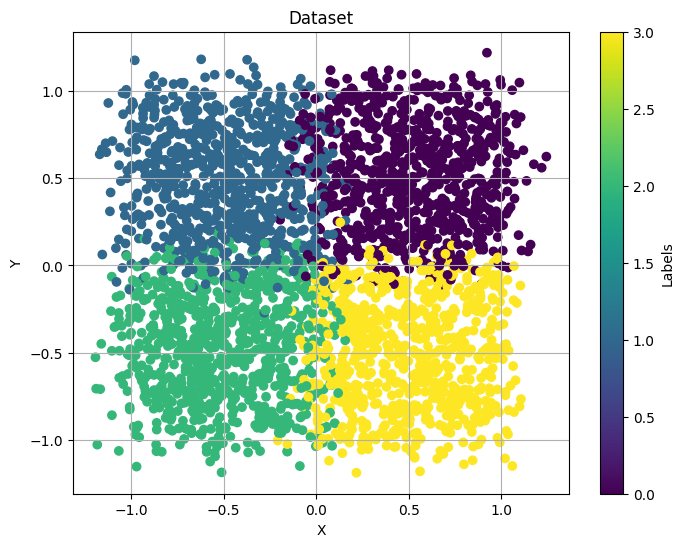

In [13]:
# Initialize arrays
number_of_loops = num_loops
accuracy1 = np.zeros(number_of_loops)
accuracy2 = np.zeros(number_of_loops)
accuracy3 = np.zeros(number_of_loops)
accuracy4 = np.zeros(number_of_loops)
accuracy5 = np.zeros(number_of_loops)
accuracy6 = np.zeros(number_of_loops)
accuracy7 = np.zeros(number_of_loops)
accuracy8 = np.zeros(number_of_loops)
accuracy9 = np.zeros(number_of_loops)

actual_epochs = np.zeros([number_of_loops, 9])
successes = np.zeros([number_of_loops, 9])


robust_accuracy1 = np.zeros((number_of_loops,number_of_epsilons))
robust_accuracy2 = np.zeros((number_of_loops,number_of_epsilons))
robust_accuracy3 = np.zeros((number_of_loops,number_of_epsilons))
robust_accuracy4 = np.zeros((number_of_loops,number_of_epsilons))
robust_accuracy5 = np.zeros((number_of_loops,number_of_epsilons))
robust_accuracy6 = np.zeros((number_of_loops,number_of_epsilons))
robust_accuracy7 = np.zeros((number_of_loops,number_of_epsilons))
robust_accuracy8 = np.zeros((number_of_loops,number_of_epsilons))
robust_accuracy9 = np.zeros((number_of_loops,number_of_epsilons))




for loop in range(num_loops):

  # Generate datasets
  points_tensor, labels_tensor = GenerateSquareDataset(noise=noise,num_points=num_points)
  test_points_tensor, test_labels_tensor = GenerateSquareDataset(noise=False, num_points=num_test_points)

  # Instantiate models
  model1 = ExpansiveContractiveNet(inner_layers, nl=ReLU)
  model2 = ExpansiveContractiveNet(inner_layers, nl=LeakyReLU)
  model3 = ExpansiveContractiveNet(inner_layers, nl=Softplus)
  model4 = ExpansiveContractiveNet(inner_layers, nl=LeakySoftplus)
  model5 = ExpansiveContractiveNet(inner_layers, nl=SemiLeakySoftplus)
  model6 = ExpansiveContractiveNet(inner_layers, nl=Tanh)
  model7 = ExpansiveContractiveNet(inner_layers, nl=LeakyTanh)
  model8 = ExpansiveContractiveNet(inner_layers, nl=Sigmoid)
  model9 = ExpansiveContractiveNet(inner_layers, nl=LeakySigmoid)

  # Train and attack the models
  actual_epochs[loop, 0], successes[loop,0] = TrainAndAttack(model1,batch_size, number_of_loops, number_of_epsilons, points_tensor, labels_tensor, accuracy1, robust_accuracy1, test_points_tensor,test_labels_tensor)

  actual_epochs[loop, 1], successes[loop,1] = TrainAndAttack(model2,batch_size, number_of_loops, number_of_epsilons, points_tensor, labels_tensor, accuracy2, robust_accuracy2, test_points_tensor,test_labels_tensor)

  actual_epochs[loop, 2], successes[loop,2] = TrainAndAttack(model3,batch_size, number_of_loops, number_of_epsilons, points_tensor, labels_tensor, accuracy3, robust_accuracy3, test_points_tensor,test_labels_tensor)

  actual_epochs[loop, 3], successes[loop,3] = TrainAndAttack(model4,batch_size, number_of_loops, number_of_epsilons, points_tensor, labels_tensor, accuracy4, robust_accuracy4, test_points_tensor,test_labels_tensor)

  actual_epochs[loop, 4], successes[loop,4] = TrainAndAttack(model5,batch_size, number_of_loops, number_of_epsilons, points_tensor, labels_tensor, accuracy5, robust_accuracy5, test_points_tensor,test_labels_tensor)

  actual_epochs[loop, 5], successes[loop,5] = TrainAndAttack(model6,batch_size, number_of_loops, number_of_epsilons, points_tensor, labels_tensor, accuracy6, robust_accuracy6, test_points_tensor,test_labels_tensor)

  actual_epochs[loop, 6], successes[loop,6] = TrainAndAttack(model7,batch_size, number_of_loops, number_of_epsilons, points_tensor, labels_tensor, accuracy7, robust_accuracy7, test_points_tensor,test_labels_tensor)

  actual_epochs[loop, 7], successes[loop,7] = TrainAndAttack(model8,batch_size, number_of_loops, number_of_epsilons, points_tensor, labels_tensor, accuracy8, robust_accuracy8, test_points_tensor,test_labels_tensor)

  actual_epochs[loop, 8], successes[loop,8] = TrainAndAttack(model9,batch_size, number_of_loops, number_of_epsilons, points_tensor, labels_tensor, accuracy9, robust_accuracy9, test_points_tensor,test_labels_tensor)

  # Visualize the last dataset
  if loop == number_of_loops-1 :
    plt.figure(figsize=(8, 6))
    plt.scatter(points_tensor[:, 0], points_tensor[:, 1], c=labels_tensor, cmap='viridis')
    plt.colorbar(label='Labels')
    plt.title('Dataset')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.grid(True)
    plt.show()



In [14]:
actual_epochs = np.transpose(actual_epochs)
successes = np.transpose(successes)

print('Successes, row = model, collumn = loop:')
print(successes)


train_accuracies = [
    accuracy1, accuracy2, accuracy3,
    accuracy4, accuracy5, accuracy6,
    accuracy7, accuracy8, accuracy9
]
train_accuracies = np.array(train_accuracies)

robust_accuracies = [
    robust_accuracy1, robust_accuracy2, robust_accuracy3,
    robust_accuracy4, robust_accuracy5, robust_accuracy6,
    robust_accuracy7, robust_accuracy8, robust_accuracy9
]

# Filter the accuracies to exclude failed runs
marked_train_accuracies = np.where(successes == 0, train_accuracies, np.nan)
average_successful_train_accuracies = np.nanmean(marked_train_accuracies, axis=1)

# Filter the robust accuracies to exclude failed runs
marked_robust_accuracies = robust_accuracies
marked_robust_accuracies = np.array(marked_robust_accuracies)
for j in range(number_of_loops):
  for i in range(9):
    if successes[i,j] == -1:
      marked_robust_accuracies[i,j] = np.nan

average_successful_robust_accuracies = np.zeros_like(average_successful_train_accuracies)
for i in range(9):
  average_successful_robust_accuracies[i] = np.nanmean(marked_robust_accuracies[i,:,:])

Successes, row = model, collumn = loop:
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


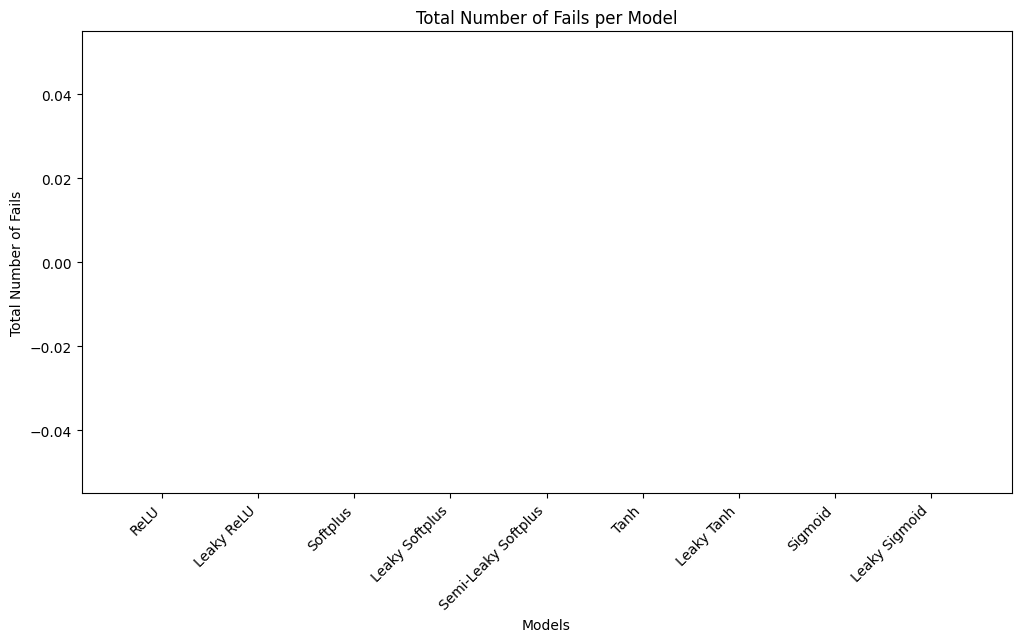

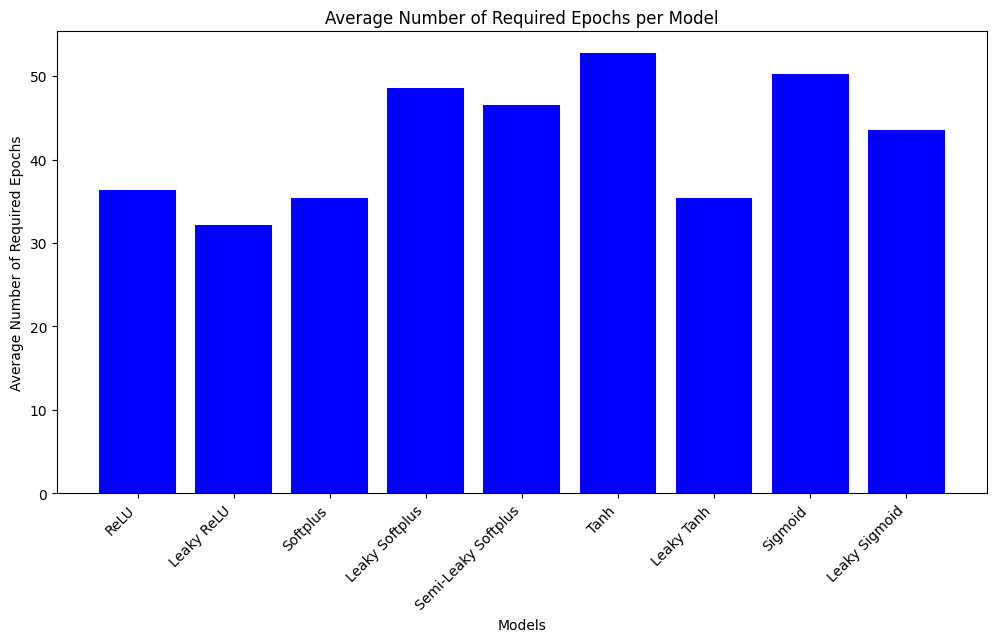

In [15]:
# Calculate the total number of fails per model
fails_per_model = np.sum(successes == -1, axis=1)

# Calculate the average number of required epochs per model (excluding failed ones)
avg_epochs_per_model = np.where(successes != -1, actual_epochs, np.nan)
avg_epochs_per_model = np.nanmean(avg_epochs_per_model, axis=1)

# Plot the total number of fails per model
plt.figure(figsize=(12, 6))
plt.bar(model_names, fails_per_model, color='red')
plt.xlabel('Models')
plt.ylabel('Total Number of Fails')
plt.title('Total Number of Fails per Model')
plt.xticks(rotation=45, ha='right')
plt.show()

# Plot the average number of required epochs per model
plt.figure(figsize=(12, 6))
plt.bar(model_names, avg_epochs_per_model, color='blue')
plt.xlabel('Models')
plt.ylabel('Average Number of Required Epochs')
plt.title('Average Number of Required Epochs per Model')
plt.xticks(rotation=45, ha='right')
plt.show()

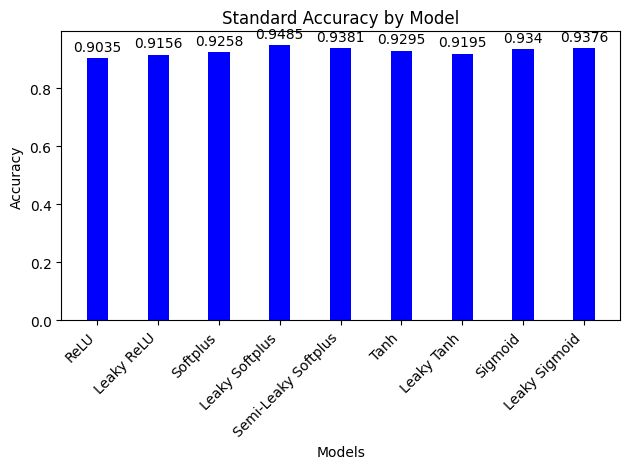

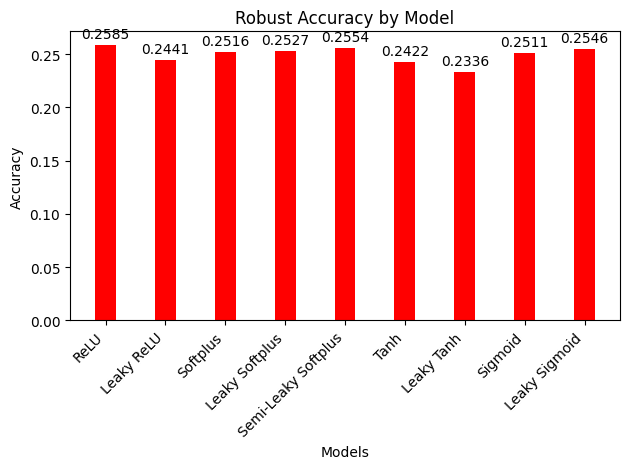

In [16]:
# Plot accuracies
n_models = len(average_successful_train_accuracies)  # Number of models
ind = np.arange(n_models)  # the x locations for the groups
width = 0.35  # the width of the bars

# Plotting standard accuracies
fig1, ax1 = plt.subplots()
train_bars = ax1.bar(ind, average_successful_train_accuracies, width, label='Standard', color='b')

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax1.set_xlabel('Models')
ax1.set_ylabel('Accuracy')
ax1.set_title('Standard Accuracy by Model')
ax1.set_xticks(ind)
ax1.set_xticklabels(model_names, rotation=45, ha="right")

def autolabel(bars, ax):
    """Attach a text label above each bar in *bars*, displaying its height."""
    for bar in bars:
        height = bar.get_height()
        ax.annotate('{}'.format(round(height, 4)),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(train_bars, ax1)

fig1.tight_layout()

# Plotting robust accuracies
fig2, ax2 = plt.subplots()
robust_bars = ax2.bar(ind, average_successful_robust_accuracies, width, label='Robust', color='r')

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax2.set_xlabel('Models')
ax2.set_ylabel('Accuracy')
ax2.set_title('Robust Accuracy by Model')
ax2.set_xticks(ind)
ax2.set_xticklabels(model_names, rotation=45, ha="right")

autolabel(robust_bars, ax2)

fig2.tight_layout()

# Show both plots
plt.show()

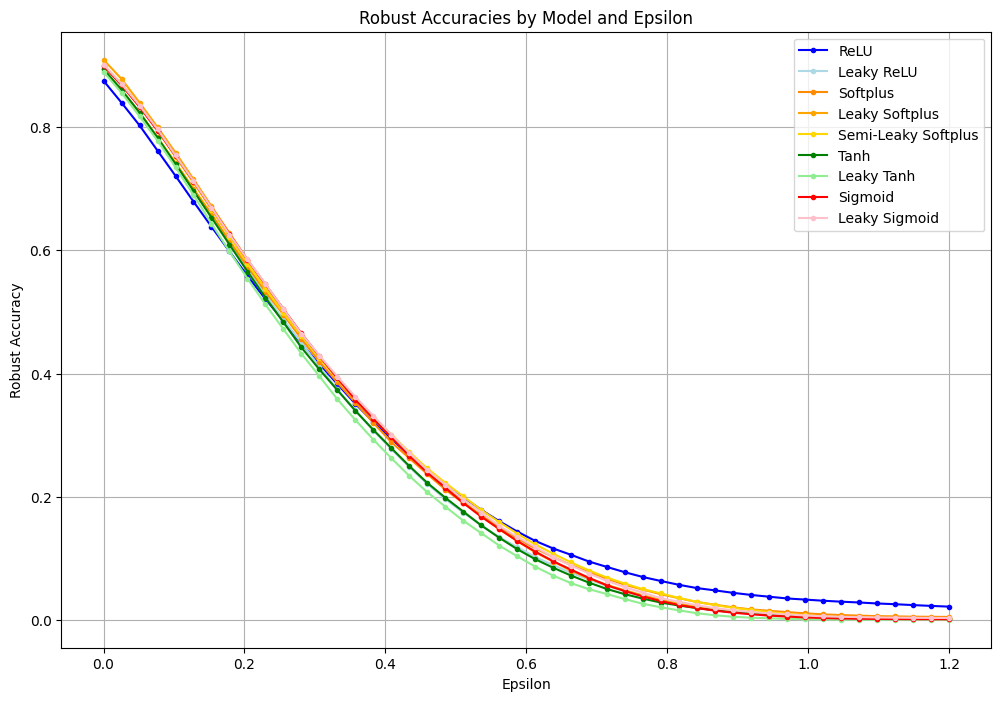

In [17]:
# Filter the robust accuracies to exclude failed runs
average_epsilon_attacks = np.zeros([9, number_of_epsilons])
for i in range(9):
  for j in range(number_of_loops):
    average_epsilon_attacks[i] = np.nanmean(marked_robust_accuracies[i,:,:], axis=0)


accuracies = [
    robust_accuracy1.mean(axis=0), robust_accuracy2.mean(axis=0), robust_accuracy3.mean(axis=0),
    robust_accuracy4.mean(axis=0), robust_accuracy5.mean(axis=0), robust_accuracy6.mean(axis=0),
    robust_accuracy7.mean(axis=0), robust_accuracy8.mean(axis=0), robust_accuracy9.mean(axis=0)
]

plt.figure(figsize=(12, 8))

# Plot each line with corresponding color
for i, array in enumerate(average_epsilon_attacks):
    plt.plot(epsilons, array, marker='.', color=colors[i], label=model_names[i])

# Add labels and legend
plt.xlabel('Epsilon')
plt.ylabel('Robust Accuracy')
plt.title('Robust Accuracies by Model and Epsilon')
plt.legend()
plt.grid(True)

# Show plot
plt.show()

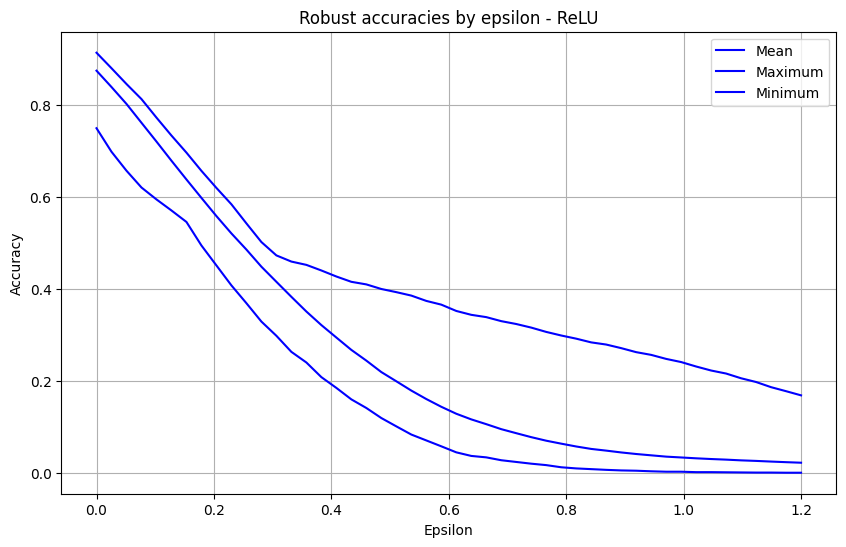

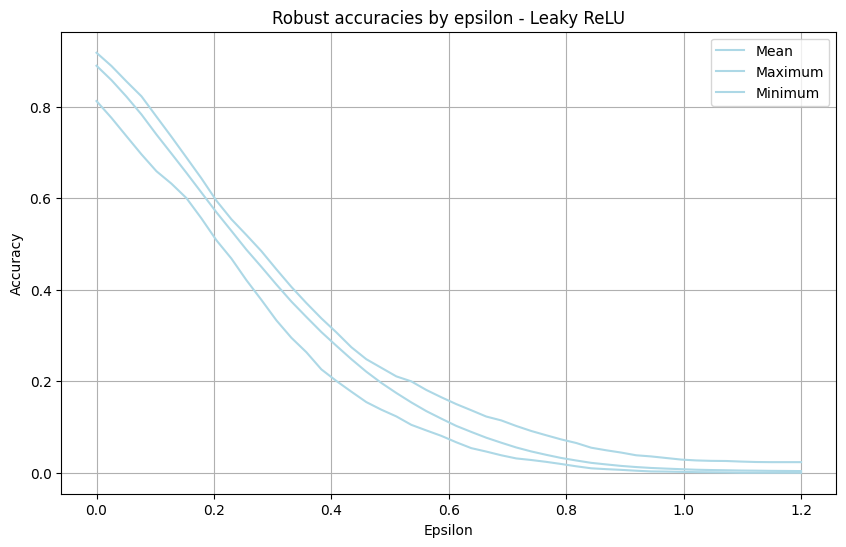

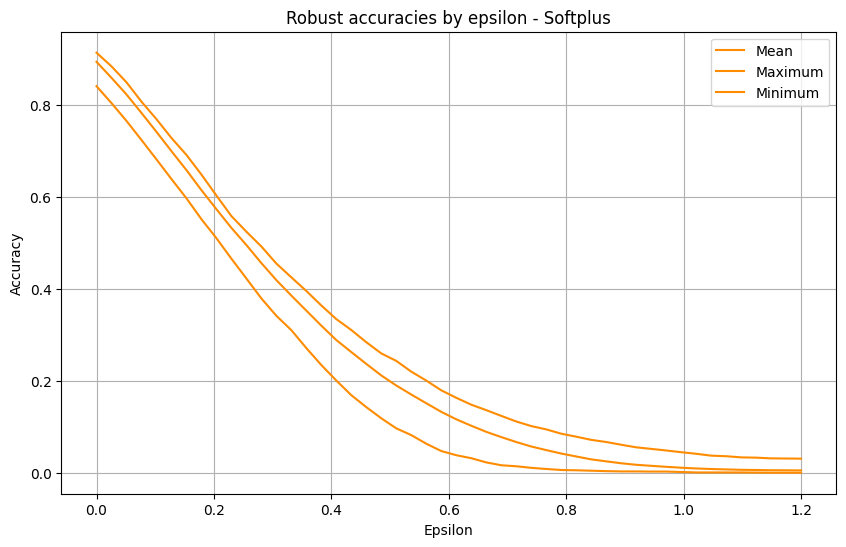

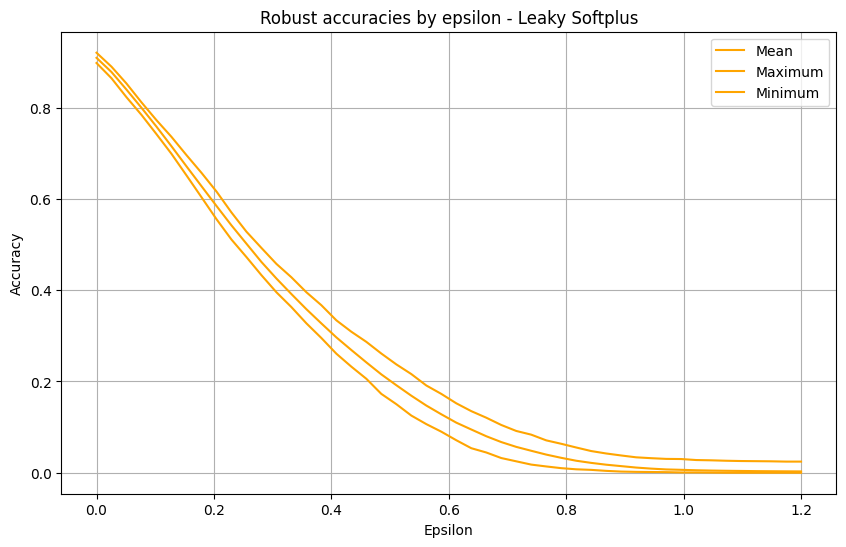

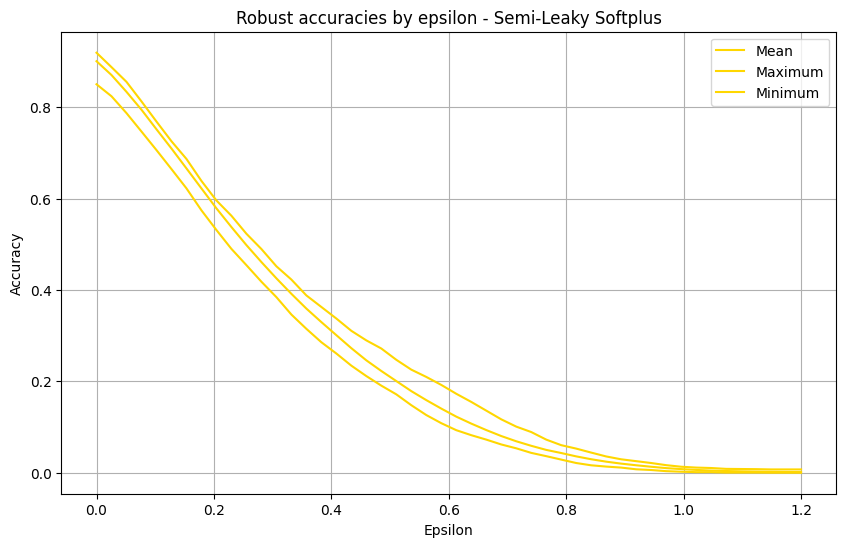

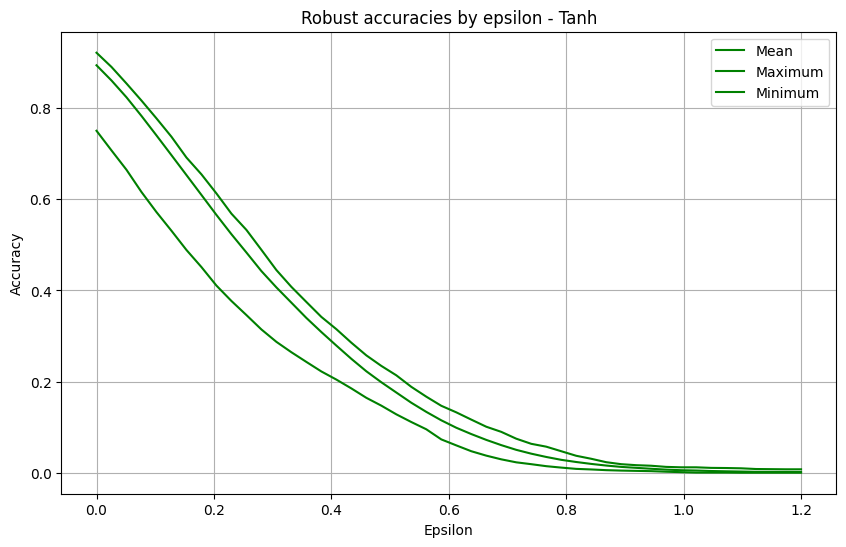

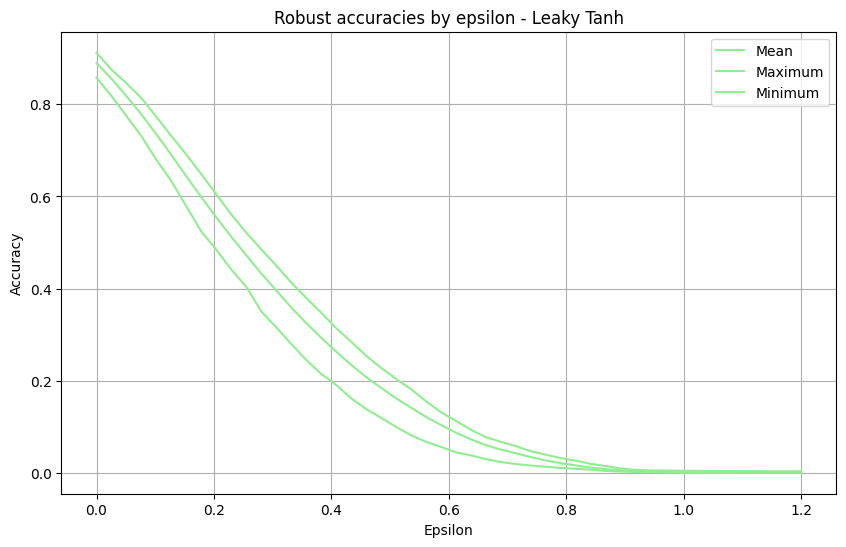

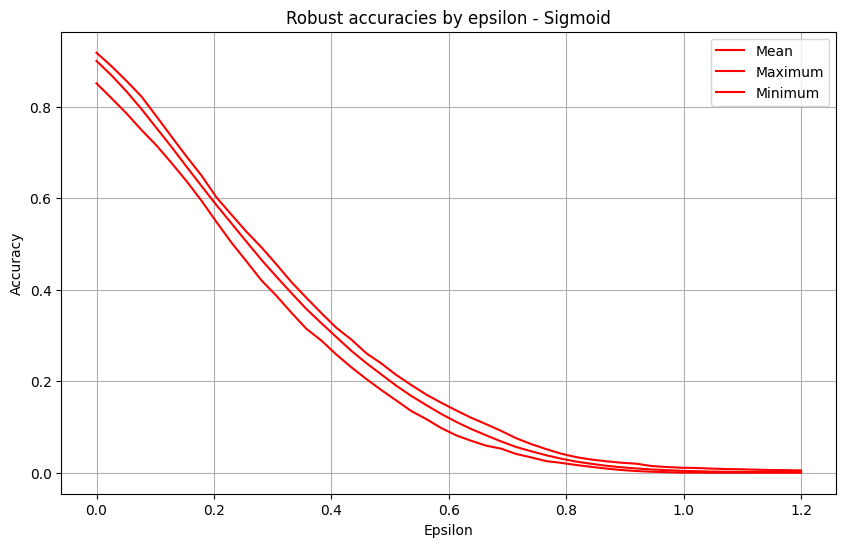

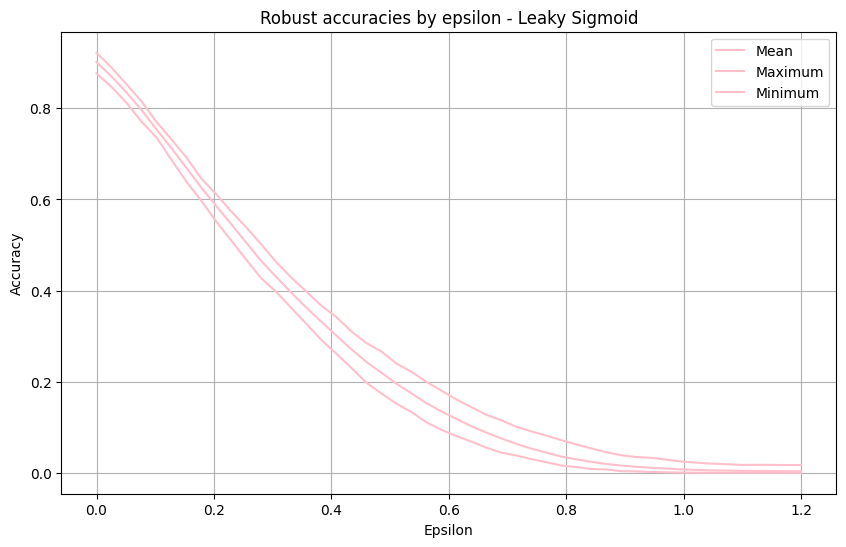

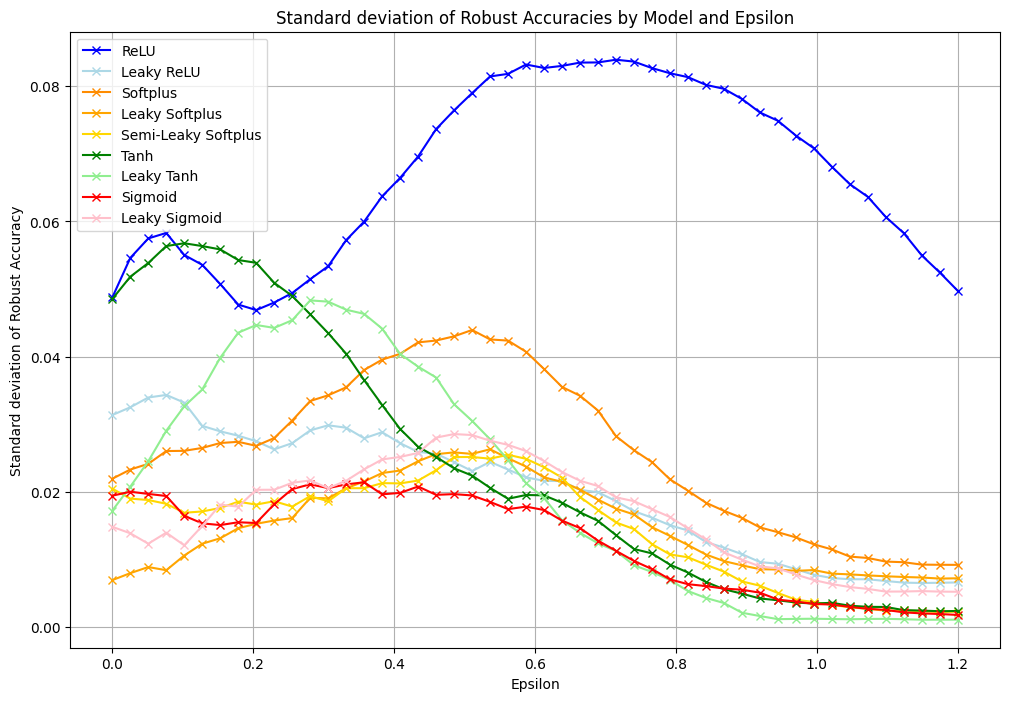

In [18]:
# Robust accuracy per model + variance and minina and maxima
maxima = np.zeros([9, number_of_epsilons])
minima = np.zeros([9, number_of_epsilons])

for i in range(9):
  maxima[i] = np.nanmax(marked_robust_accuracies[i,:,:],axis=0)
  minima[i] = np.nanmin(marked_robust_accuracies[i,:,:],axis=0)

n_models = len(marked_robust_accuracies)
var_accuracies = np.zeros((n_models, len(epsilons)))

# Plot each line with error bars for mean, max, and min accuracies
for i, array in enumerate(average_epsilon_attacks):
    plt.figure(figsize=(10, 6))
    var_accuracies[i] = np.nanstd(marked_robust_accuracies[i], axis=0)

    plt.plot(epsilons, array, label='Mean', color=colors[i])
    plt.plot(epsilons, maxima[i], label='Maximum', color=colors[i])
    plt.plot(epsilons, minima[i], label='Minimum', color=colors[i])

    # Add labels and legend
    plt.xlabel('Epsilon')
    plt.ylabel('Accuracy')
    plt.title('Robust accuracies by epsilon - ' + model_names[i])
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot the variation on robust accuracies
plt.figure(figsize=(12, 8))
for i, array in enumerate(var_accuracies):
    plt.plot(epsilons, array, marker='x', label=model_names[i], color=colors[i])

# Add labels and legend
plt.xlabel('Epsilon')
plt.ylabel('Standard deviation of Robust Accuracy')
plt.title('Standard deviation of Robust Accuracies by Model and Epsilon')
plt.legend()
plt.grid(True)
plt.show()

In [19]:
# # Combine accuracies for all models
# MCHall_accuracies = [MCHaccuracies1, MCHaccuracies2, MCHaccuracies3, MCHaccuracies4, MCHaccuracies5, MCHaccuracies6, MCHaccuracies7, MCHaccuracies8, MCHaccuracies9]

# MCHall_accuracies = np.array(MCHall_accuracies)

# for i in range(9):
#   for j in range(num_loops):
#     if successes[i,j] == 0:
#       MCHall_accuracies[i,j] = np.nan

# print(successes)
# # Remove NaN values for plotting
# filtered_accuracies = [acc[~np.isnan(acc)] for acc in MCHall_accuracies]

# print(filtered_accuracies)

# # Plotting
# plt.boxplot(filtered_accuracies, labels=model_names)
# plt.xlabel('Models')
# plt.ylabel('Accuracy')
# plt.title('Accuracy Distribution Across Models')
# plt.grid(True)
# plt.xticks(rotation=45)
# plt.show()

In [20]:
# # List of train accuracies for 9 models
# MCHtrain_accuracies = [
#     np.nanmean(MCHaccuracies1), np.nanmean(MCHaccuracies2), np.nanmean(MCHaccuracies3),
#     np.nanmean(MCHaccuracies4), np.nanmean(MCHaccuracies5), np.nanmean(MCHaccuracies6),
#     np.nanmean(MCHaccuracies7), np.nanmean(MCHaccuracies8), np.nanmean(MCHaccuracies9)
# ]

# # List of robust accuracies for 9 models
# MCHrobust_accuracies = [
#     np.nanmean(MCHrobust_accuracy1), np.nanmean(MCHrobust_accuracy2), np.nanmean(MCHrobust_accuracy3),
#     np.nanmean(MCHrobust_accuracy4), np.nanmean(MCHrobust_accuracy5), np.nanmean(MCHrobust_accuracy6),
#     np.nanmean(MCHrobust_accuracy7), np.nanmean(MCHrobust_accuracy8), np.nanmean(MCHrobust_accuracy9)
# ]

# ind = np.arange(n_models)  # the x locations for the groups
# width = 0.35  # the width of the bars

# fig, ax = plt.subplots(figsize=(12, 8))
# MCHtrain_bars = ax.bar(ind - width/2, MCHtrain_accuracies, width, label='Normal')
# MCHrobust_bars = ax.bar(ind + width/2, MCHrobust_accuracies, width, label='Robust')

# # Add some text for labels, title, and custom x-axis tick labels, etc.
# ax.set_xlabel('Models')
# ax.set_ylabel('Accuracy')
# ax.set_title('Normal and Robust Accuracy by Model')
# ax.set_xticks(ind)
# ax.set_xticklabels(model_names, rotation=45, ha='right')
# ax.legend()

# def autolabel(bars):
#     """Attach a text label above each bar in *bars*, displaying its height."""
#     for bar in bars:
#         height = bar.get_height()
#         ax.annotate('{}'.format(round(height, 4)),
#                     xy=(bar.get_x() + bar.get_width() / 2, height),
#                     xytext=(0, 3),  # 3 points vertical offset
#                     textcoords="offset points",
#                     ha='center', va='bottom')

# autolabel(MCHtrain_bars)
# autolabel(MCHrobust_bars)

# fig.tight_layout()

# plt.show()

In [21]:
# # List of robust accuracies for 9 models
# MCHrobust_accuracies = [
#     MCHrobust_accuracy1, MCHrobust_accuracy2, MCHrobust_accuracy3,
#     MCHrobust_accuracy4, MCHrobust_accuracy5, MCHrobust_accuracy6,
#     MCHrobust_accuracy7, MCHrobust_accuracy8, MCHrobust_accuracy9
# ]

# # Calculate mean accuracies along the second axis (assuming it's the correct axis)
# MCHaccuracies = [np.nanmean(acc, axis=0) for acc in MCHrobust_accuracies]

# plt.figure(figsize=(10, 6))

# # Plot each line
# for i, array in enumerate(MCHaccuracies):
#     plt.plot(epsilons, array, marker='.', label=model_names[i])

# # Add labels and legend
# plt.xlabel('Epsilon')
# plt.ylabel('Accuracy')
# plt.title('Robust accuracies by model and epsilon')
# plt.legend()

# # Show plot
# plt.grid(True)
# plt.show()

In [22]:
# MCHrobust_accuracies = [
#     MCHrobust_accuracy1, MCHrobust_accuracy2, MCHrobust_accuracy3,
#     MCHrobust_accuracy4, MCHrobust_accuracy5, MCHrobust_accuracy6,
#     MCHrobust_accuracy7, MCHrobust_accuracy8, MCHrobust_accuracy9
# ]

# # Calculate mean, maxima, and minima accuracies along the second axis
# MCHrobust_accuracies_mean = [np.mean(acc, axis=0) for acc in MCHrobust_accuracies]
# MCHmaxima = [np.max(acc, axis=0) for acc in MCHrobust_accuracies]
# MCHminima = [np.min(acc, axis=0) for acc in MCHrobust_accuracies]

# MCHrobust_accuracies_mean = [MCHrobust_accuracy1.mean(axis=0), MCHrobust_accuracy2.mean(axis=0), MCHrobust_accuracy3.mean(axis=0),
# MCHrobust_accuracy4.mean(axis=0), MCHrobust_accuracy5.mean(axis=0),
# MCHrobust_accuracy6.mean(axis=0), MCHrobust_accuracy7.mean(axis=0),
# MCHrobust_accuracy8.mean(axis=0), MCHrobust_accuracy9.mean(axis=0)]

# MCHvar_accuracies = np.zeros((n_models,len(epsilons)))
# # Plot each line with error bars
# for i, array in enumerate(MCHrobust_accuracies_mean):
#     plt.figure(figsize=(10, 6))
#     MCHvar_accuracies[i] = np.std(MCHrobust_accuracies[i], axis=0)

#     plt.plot(epsilons, array, label='Mean', color=colors[i])
#     plt.plot(epsilons, MCHmaxima[i], linestyle='dashed', label='Maximum', color=colors[i])
#     plt.plot(epsilons, MCHminima[i], linestyle='dotted', label='Minimum', color=colors[i])
#     # Add labels and legend
#     plt.xlabel('Epsilon')
#     plt.ylabel('Accuracy')
#     plt.title('Robust accuracies by epsilon - ' + model_names[i])
#     plt.legend()

#     # Show plot
#     plt.grid(True)
#     plt.show()


# plt.figure(figsize=(10, 6))
# # Plot each line
# for i, array in enumerate(MCHvar_accuracies):
#     plt.plot(epsilons, array, marker='x', label=model_names[i], color=colors[i])


# # Add labels and legend
# plt.xlabel('Epsilon')
# plt.ylabel('Variation on Robust Accuracy')
# plt.title('Variation on Robust accuracies by model and epsilon')
# plt.legend()

# # Show plot
# plt.grid(True)
# plt.show()

In [23]:
# model = ExpansiveContractiveNet(inner_layers, nl=LeakyReLU)

# # Define loss function and optimizer
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# points_tensor, labels_tensor = GenerateSquareDataset(noise=noise,num_points=num_points)

# # Training the model
# for epoch in range(num_epochs):
#     for i in range(0, len(points_tensor), batch_size):
#         batch_points = points_tensor[i:i+batch_size]
#         batch_labels = labels_tensor[i:i+batch_size]

#         # Forward pass
#         outputs = model(batch_points)
#         loss = criterion(outputs, batch_labels)

#         # Backward pass and optimization
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#     print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# # Evaluate the model
# with torch.no_grad():
#     outputs = model(points_tensor)  # Add channel dimension
#     _, predicted = torch.max(outputs, 1)
#     accuracy = (predicted == labels_tensor).float().mean()
#     print(f'Accuracy: {accuracy.item()*100:.2f}%')

In [24]:
# MCHmin_robust_accuracies = [MCHrobust_accuracy1.min(), MCHrobust_accuracy2.min(), MCHrobust_accuracy3.min(), MCHrobust_accuracy4.min(), MCHrobust_accuracy5.min()]
# MCHmax_robust_accuracies = [MCHrobust_accuracy1.max(), MCHrobust_accuracy2.max(), MCHrobust_accuracy3.max(), MCHrobust_accuracy4.max(), MCHrobust_accuracy5.max()]
# model_names = ['Leaky ReLU', 'Leaky Softplus', 'Semi-Leaky Softplus', 'Leaky Tanh', 'Tanh']

# n_models = len(MCHtrain_accuracies)  # Number of models
# ind = np.arange(n_models)  # the x locations for the groups
# width = 0.35  # the width of the bars

# fig, ax = plt.subplots()
# MCHmin_bars = ax.bar(ind - width/2, MCHmin_robust_accuracies, width, label='Min')
# MCHmax_bars = ax.bar(ind + width/2, MCHmax_robust_accuracies, width, label='Max')

# # Add some text for labels, title, and custom x-axis tick labels, etc.
# ax.set_xlabel('Models')
# ax.set_ylabel('Accuracy')
# ax.set_title('Min. and Max. Robust Accuracy by Model')
# ax.set_xticks(ind)
# ax.set_xticklabels(model_names)
# ax.legend()

# def autolabel(bars):
#     """Attach a text label above each bar in *bars*, displaying its height."""
#     for bar in bars:
#         height = bar.get_height()
#         ax.annotate('{}'.format(round(height, 4)),
#                     xy=(bar.get_x() + bar.get_width() / 2, height),
#                     xytext=(0, 3),  # 3 points vertical offset
#                     textcoords="offset points",
#                     ha='center', va='bottom')

# autolabel(MCHmin_bars)
# autolabel(MCHmax_bars)

# fig.tight_layout()

# plt.show()